Using device: cpu
Total rows: 50000
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
Vocabulary size (including PAD & UNK): 20002
Splits -> train: 40000 val: 5000 test: 5000
LSTMSentiment(
  (embedding): Embedding(20002, 100, padding_idx=0)
  (lstm): LSTM(100, 128, batch_first=True, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)
Epoch 1/6: train_loss=0.6690  val_loss=0.6145
Epoch 2/6: train_loss=0.5358  val_loss=0.4933
Epoch 3/6: train_loss=0.4188  val_loss=0.4142
Epoch 4/6: train_loss=0.3113

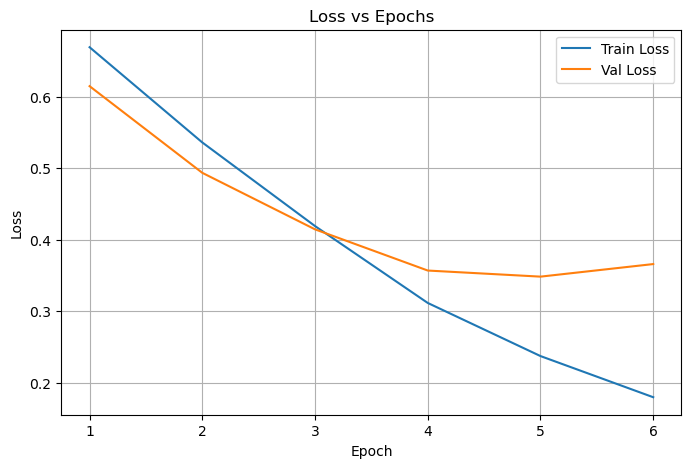

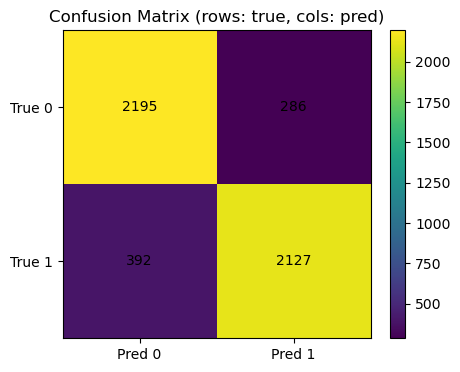

Saved model and vocabulary to output


In [3]:
import re
import os
import random
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# ----------------------------
# Config / Hyperparameters
# ----------------------------
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

CSV_PATH = "reviews.csv"         
TEXT_COL = "review"             
LABEL_COL = "sentiment"           
LABEL_POS_PREFIX = "pos"          

PAD_IDX = 0
UNK_IDX = 1

# Model / training hyperparams 
EMBEDDING_DIM = 100
HIDDEN_SIZE = 128
BIDIRECTIONAL = True
NUM_LAYERS = 1
DROPOUT = 0.2

BATCH_SIZE = 64
LEARNING_RATE = 1e-3
EPOCHS = 6

MAX_VOCAB_SIZE = 20000
MAX_SEQ_LEN = 200                

OUTPUT_DIR = "output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# ----------------------------
# Load & Inspect
# ----------------------------
df = pd.read_csv(CSV_PATH)
print("Total rows:", len(df))
print(df.head())

# ----------------------------
# Preprocessing
# ----------------------------
def clean_text(text):
    """Lowercase, strip HTML tags, remove non-alphanum chars and collapse whitespace."""
    text = str(text).lower()
    # remove basic HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    # keep letters and digits, replace others with space
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning
df["clean"] = df[TEXT_COL].apply(clean_text)
df["tokens"] = df["clean"].apply(lambda t: t.split())

# Convert labels to 0/1 (binary)
df[LABEL_COL] = df[LABEL_COL].astype(str).apply(lambda s: 1 if s.lower().strip().startswith(LABEL_POS_PREFIX) else 0)

# Shuffle
df = df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

# ----------------------------
# Build vocabulary 
# ----------------------------
counter = Counter()
for toks in df["tokens"]:
    counter.update(toks)

most_common = counter.most_common(MAX_VOCAB_SIZE)
word2idx = {"<PAD>": PAD_IDX, "<UNK>": UNK_IDX}
idx = 2
for w, _ in most_common:
    word2idx[w] = idx
    idx += 1

vocab_size = len(word2idx)
print("Vocabulary size (including PAD & UNK):", vocab_size)

def tokens_to_indices(tokens, max_len=MAX_SEQ_LEN):
    # Map tokens to indices; truncate to max_len; pad with PAD_IDX
    ids = [word2idx.get(t, UNK_IDX) for t in tokens[:max_len]]
    if len(ids) < max_len:
        ids += [PAD_IDX] * (max_len - len(ids))
    return ids

df["input_ids"] = df["tokens"].apply(lambda t: tokens_to_indices(t, MAX_SEQ_LEN))

# ----------------------------
# Train / Val / Test split (80/10/10)
# ----------------------------
n = len(df)
n_train = int(0.8 * n)
n_val = int(0.1 * n)
train_df = df.iloc[:n_train].reset_index(drop=True)
val_df = df.iloc[n_train:n_train + n_val].reset_index(drop=True)
test_df = df.iloc[n_train + n_val:].reset_index(drop=True)
print("Splits -> train:", len(train_df), "val:", len(val_df), "test:", len(test_df))

# ----------------------------
# Dataset & DataLoader
# ----------------------------
class ReviewsDataset(Dataset):
    def __init__(self, df):
        self.inputs = np.stack(df["input_ids"].values).astype(np.int64)
        self.labels = df[LABEL_COL].values.astype(np.float32)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.float32)

train_ds = ReviewsDataset(train_df)
val_ds = ReviewsDataset(val_df)
test_ds = ReviewsDataset(test_df)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

# ----------------------------
# LSTM Model
# ----------------------------
class LSTMSentiment(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, padding_idx=PAD_IDX,
                 num_layers=1, bidirectional=True, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=emb_dim, padding_idx=padding_idx)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, bidirectional=bidirectional, dropout=dropout if num_layers > 1 else 0.0)
        factor = 2 if bidirectional else 1
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * factor, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)  # one logit
        )
    def forward(self, x):
        emb = self.embedding(x)                       # (batch, seq_len, emb_dim)
        out, (h_n, c_n) = self.lstm(emb)              # h_n shape: (num_layers * num_directions, batch, hidden_dim)
        if self.lstm.bidirectional:
            # last layer forward is h_n[-2], backward is h_n[-1]
            h_forward = h_n[-2]
            h_backward = h_n[-1]
            h = torch.cat([h_forward, h_backward], dim=1)
        else:
            h = h_n[-1]
        logits = self.fc(h).squeeze(1)
        return logits

model = LSTMSentiment(vocab_size=vocab_size, emb_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_SIZE,
                      padding_idx=PAD_IDX, num_layers=NUM_LAYERS, bidirectional=BIDIRECTIONAL, dropout=DROPOUT)
model = model.to(DEVICE)
print(model)

# ----------------------------
# Loss & Optimizer
# ----------------------------
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# ----------------------------
# Training loop
# ----------------------------
def evaluate_loss(dataloader):
    model.eval()
    total_loss = 0.0
    n = 0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(DEVICE)
            y = y.to(DEVICE)
            logits = model(X)
            loss = criterion(logits, y)
            total_loss += loss.item() * X.size(0)
            n += X.size(0)
    return total_loss / n if n > 0 else 0.0

train_losses, val_losses = [], []
for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    n = 0
    for X, y in train_loader:
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X.size(0)
        n += X.size(0)
    train_loss = running_loss / n
    val_loss = evaluate_loss(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch}/{EPOCHS}: train_loss={train_loss:.4f}  val_loss={val_loss:.4f}")

# ----------------------------
# Evaluation on test set
# ----------------------------
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(DEVICE)
        logits = model(X)
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs >= 0.5).astype(int)
        all_preds.extend(preds.tolist())
        all_labels.extend(y.numpy().astype(int).tolist())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

tp = int(((all_preds == 1) & (all_labels == 1)).sum())
tn = int(((all_preds == 0) & (all_labels == 0)).sum())
fp = int(((all_preds == 1) & (all_labels == 0)).sum())
fn = int(((all_preds == 0) & (all_labels == 1)).sum())

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

print("\nTest results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("Confusion matrix (TP, FP, FN, TN):", tp, fp, fn, tn)

# ----------------------------
# Plots: Loss vs Epochs and Confusion Matrix
# ----------------------------
plt.figure(figsize=(8,5))
plt.plot(range(1, EPOCHS + 1), train_losses, label="Train Loss")
plt.plot(range(1, EPOCHS + 1), val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

cm = np.array([[tn, fp], [fn, tp]])
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (rows: true, cols: pred)")
plt.colorbar()
plt.xticks([0,1], ["Pred 0","Pred 1"])
plt.yticks([0,1], ["True 0","True 1"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(int(cm[i,j])), ha='center', va='center')
plt.show()

# ----------------------------
# Save artifacts
# ----------------------------
torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, "lstm_sentiment_model.pt"))
pd.to_pickle(word2idx, os.path.join(OUTPUT_DIR, "word2idx.pkl"))
print("Saved model and vocabulary to", OUTPUT_DIR)


# Advanced

Device: cpu
Raw rows: 50000
Vocab size: 20002
Split sizes (train/val/test): 40000 5000 5000

======== Training: RNN ========
Epoch 1/6 - train_loss: 0.6938  val_loss: 0.6929  val_acc: 0.5050
Epoch 2/6 - train_loss: 0.6948  val_loss: 0.6931  val_acc: 0.5052
Epoch 3/6 - train_loss: 0.6934  val_loss: 0.6926  val_acc: 0.5164
Epoch 4/6 - train_loss: 0.6934  val_loss: 0.6931  val_acc: 0.5108
Epoch 5/6 - train_loss: 0.6932  val_loss: 0.6931  val_acc: 0.5094
Epoch 6/6 - train_loss: 0.6933  val_loss: 0.6932  val_acc: 0.4960
RNN test -> Acc: 0.5042, Prec: 0.5187, Rec: 0.2203, F1: 0.3093

======== Training: LSTM ========
Epoch 1/6 - train_loss: 0.6933  val_loss: 0.6931  val_acc: 0.5018
Epoch 2/6 - train_loss: 0.6924  val_loss: 0.6923  val_acc: 0.5096
Epoch 3/6 - train_loss: 0.6671  val_loss: 0.6846  val_acc: 0.5302
Epoch 4/6 - train_loss: 0.5538  val_loss: 0.4734  val_acc: 0.7916
Epoch 5/6 - train_loss: 0.4073  val_loss: 0.4344  val_acc: 0.8132
Epoch 6/6 - train_loss: 0.3334  val_loss: 0.3725  va

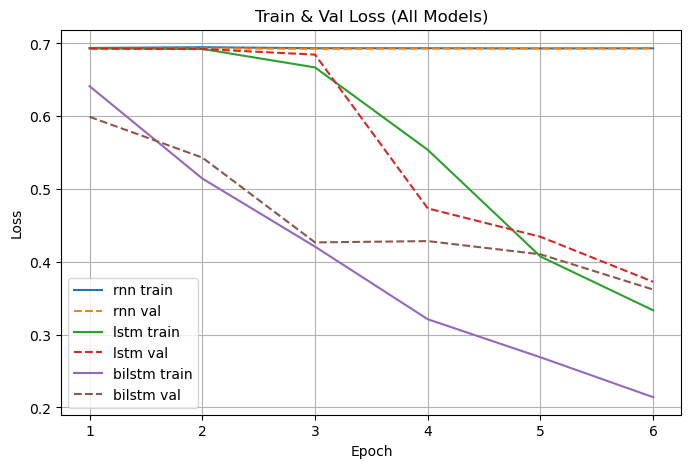


Model comparison on test set:
    Model  Accuracy  Precision    Recall        F1
0     RNN    0.5042   0.518692  0.220326  0.309278
1    LSTM    0.8580   0.851809  0.869393  0.860511
2  BILSTM    0.8640   0.894805  0.827312  0.859736

RNN confusion matrix:
[[1966  515]
 [1964  555]]

LSTM confusion matrix:
[[2100  381]
 [ 329 2190]]

BILSTM confusion matrix:
[[2236  245]
 [ 435 2084]]

Ensemble results:
          Method  Accuracy  Precision    Recall        F1
0  MAJORITY_VOTE    0.8608   0.905291  0.808257  0.854027
1      AVG_PROBS    0.8838   0.899752  0.865820  0.882460
Saved artifacts to ./output

--- QUICK INSIGHTS ---
Best single model by F1: LSTM with F1=0.8605
Compare ensembles vs best single model above. If ensemble improves F1, ensembling helped.


In [5]:
import os, re, random
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

CSV_PATH = "reviews.csv"   
TEXT_COL = "review"
LABEL_COL = "sentiment"
LABEL_POS_PREFIX = "pos"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


MAX_SAMPLES = None        
MAX_VOCAB_SIZE = 20000
MAX_SEQ_LEN = 200
PAD_IDX = 0
UNK_IDX = 1

EMBED_DIM = 100
HIDDEN_SIZE = 128
NUM_LAYERS = 1
DROPOUT = 0.3
BIDIRECTIONAL = True  # used for BiLSTM model

BATCH_SIZE = 64
LEARNING_RATE = 1e-3
EPOCHS = 6

OUTPUT_DIR = "./output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---------------------------
# Utilities: cleaning and tokenization
# ---------------------------
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'<.*?>', ' ', text)             
    text = re.sub(r'[^a-z0-9\s]', ' ', text)      
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# ---------------------------
# Load data
# ---------------------------
df = pd.read_csv(CSV_PATH)
print("Raw rows:", len(df))
df = df[[TEXT_COL, LABEL_COL]].dropna().reset_index(drop=True)
if MAX_SAMPLES:
    df = df.sample(frac=1, random_state=RANDOM_SEED).iloc[:MAX_SAMPLES].reset_index(drop=True)

# Preprocess
df["clean"] = df[TEXT_COL].apply(clean_text)
df["tokens"] = df["clean"].apply(lambda s: s.split())
df[LABEL_COL] = df[LABEL_COL].astype(str).apply(lambda s: 1 if s.lower().strip().startswith(LABEL_POS_PREFIX) else 0)
df = df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)  # shuffle

# Build vocab (PAD=0, UNK=1)
counter = Counter()
for toks in df["tokens"]:
    counter.update(toks)
most_common = counter.most_common(MAX_VOCAB_SIZE)
word2idx = {"<PAD>": PAD_IDX, "<UNK>": UNK_IDX}
idx = 2
for w, _ in most_common:
    word2idx[w] = idx; idx += 1
vocab_size = len(word2idx)
print("Vocab size:", vocab_size)

def tokens_to_indices(tokens, max_len=MAX_SEQ_LEN):
    ids = [word2idx.get(t, UNK_IDX) for t in tokens[:max_len]]
    if len(ids) < max_len:
        ids += [PAD_IDX] * (max_len - len(ids))
    return ids

df["input_ids"] = df["tokens"].apply(lambda t: tokens_to_indices(t, MAX_SEQ_LEN))

# ---------------------------
# Splits (80/10/10)
# ---------------------------
n = len(df)
n_train = int(0.8 * n)
n_val = int(0.1 * n)
train_df = df.iloc[:n_train].reset_index(drop=True)
val_df = df.iloc[n_train:n_train+n_val].reset_index(drop=True)
test_df = df.iloc[n_train+n_val:].reset_index(drop=True)
print("Split sizes (train/val/test):", len(train_df), len(val_df), len(test_df))

# ---------------------------
# Dataset & Dataloader
# ---------------------------
class ReviewsDataset(Dataset):
    def __init__(self, df):
        self.X = np.stack(df["input_ids"].values).astype(np.int64)
        self.y = df[LABEL_COL].values.astype(np.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.long), torch.tensor(self.y[idx], dtype=torch.float32)

train_loader = DataLoader(ReviewsDataset(train_df), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(ReviewsDataset(val_df), batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(ReviewsDataset(test_df), batch_size=BATCH_SIZE, shuffle=False)

# ---------------------------
# Models: RNN, LSTM, BiLSTM
# ---------------------------
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers=1, padding_idx=PAD_IDX, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=padding_idx)
        self.rnn = nn.RNN(emb_dim, hidden_dim, num_layers=num_layers, batch_first=True, nonlinearity='tanh', dropout=dropout if num_layers>1 else 0.0)
        self.fc = nn.Sequential(nn.Linear(hidden_dim, 64), nn.ReLU(), nn.Dropout(0.2), nn.Linear(64,1))
    def forward(self, x):
        emb = self.embedding(x)
        out, h_n = self.rnn(emb)   # h_n: (num_layers, batch, hidden)
        h = h_n[-1]                # last layer
        logits = self.fc(h).squeeze(1)
        return logits

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers=1, bidirectional=False, padding_idx=PAD_IDX, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=padding_idx)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=bidirectional, dropout=dropout if num_layers>1 else 0.0)
        factor = 2 if bidirectional else 1
        self.bidirectional = bidirectional
        self.fc = nn.Sequential(nn.Linear(hidden_dim * factor, 64), nn.ReLU(), nn.Dropout(0.2), nn.Linear(64,1))
    def forward(self, x):
        emb = self.embedding(x)
        out, (h_n, c_n) = self.lstm(emb)
        if self.bidirectional:
            h = torch.cat([h_n[-2], h_n[-1]], dim=1)
        else:
            h = h_n[-1]
        logits = self.fc(h).squeeze(1)
        return logits

# Helper builder
def build_model(model_type="lstm", bidirectional=False):
    if model_type == "rnn":
        m = RNNClassifier(vocab_size=vocab_size, emb_dim=EMBED_DIM, hidden_dim=HIDDEN_SIZE, num_layers=NUM_LAYERS, padding_idx=PAD_IDX, dropout=DROPOUT)
    elif model_type == "lstm":
        m = LSTMClassifier(vocab_size=vocab_size, emb_dim=EMBED_DIM, hidden_dim=HIDDEN_SIZE, num_layers=NUM_LAYERS, bidirectional=False, padding_idx=PAD_IDX, dropout=DROPOUT)
    elif model_type == "bilstm":
        m = LSTMClassifier(vocab_size=vocab_size, emb_dim=EMBED_DIM, hidden_dim=HIDDEN_SIZE, num_layers=NUM_LAYERS, bidirectional=True, padding_idx=PAD_IDX, dropout=DROPOUT)
    else:
        raise ValueError("Unknown model_type")
    return m.to(DEVICE)

# ---------------------------
# Training & evaluation functions
# ---------------------------
criterion = nn.BCEWithLogitsLoss()

def train_one(model, optimizer, loader):
    model.train()
    total_loss = 0.0
    n = 0
    for X, y in loader:
        X = X.to(DEVICE); y = y.to(DEVICE)
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        # optional gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        total_loss += loss.item() * X.size(0)
        n += X.size(0)
    return total_loss / n if n>0 else 0.0

def evaluate(model, loader):
    model.eval()
    total_loss = 0.0; n = 0
    preds = []; labels = []
    with torch.no_grad():
        for X, y in loader:
            X = X.to(DEVICE); y = y.to(DEVICE)
            logits = model(X)
            loss = criterion(logits, y)
            total_loss += loss.item() * X.size(0)
            n += X.size(0)
            probs = torch.sigmoid(logits).cpu().numpy()
            batch_preds = (probs >= 0.5).astype(int)
            preds.extend(batch_preds.tolist())
            labels.extend(y.cpu().numpy().astype(int).tolist())
    avg_loss = total_loss / n if n>0 else 0.0
    acc = accuracy_score(labels, preds)
    return avg_loss, acc, np.array(preds), np.array(labels)

# ---------------------------
# Train each model
# ---------------------------
models_to_train = [("rnn", False), ("lstm", False), ("bilstm", True)]
histories = {}
test_results = {}

for model_name, is_bi in models_to_train:
    print("\n======== Training:", model_name.upper(), "========")
    model = build_model("rnn" if model_name=="rnn" else ("bilstm" if model_name=="bilstm" else "lstm"), bidirectional=is_bi)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    train_losses = []; val_losses = []; val_accs = []
    for epoch in range(1, EPOCHS+1):
        train_loss = train_one(model, optimizer, train_loader)
        val_loss, val_acc, _, _ = evaluate(model, val_loader)
        train_losses.append(train_loss); val_losses.append(val_loss); val_accs.append(val_acc)
        print(f"Epoch {epoch}/{EPOCHS} - train_loss: {train_loss:.4f}  val_loss: {val_loss:.4f}  val_acc: {val_acc:.4f}")
    histories[model_name] = {"train_losses": train_losses, "val_losses": val_losses, "val_accs": val_accs, "model": model}
    # Evaluate on test set
    _, _, preds_test, labels_test = evaluate(model, test_loader)
    acc = accuracy_score(labels_test, preds_test)
    prec = precision_score(labels_test, preds_test, zero_division=0)
    rec = recall_score(labels_test, preds_test, zero_division=0)
    f1 = f1_score(labels_test, preds_test, zero_division=0)
    cm = confusion_matrix(labels_test, preds_test)
    test_results[model_name] = {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "confusion_matrix": cm}
    # save model weights
    torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, f"{model_name}_model.pt"))
    print(f"{model_name.upper()} test -> Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}")

# ---------------------------
# Plot Loss vs Epochs for all models
# ---------------------------
plt.figure(figsize=(8,5))
for name, h in histories.items():
    plt.plot(range(1, EPOCHS+1), h["train_losses"], label=f"{name} train")
    plt.plot(range(1, EPOCHS+1), h["val_losses"], '--', label=f"{name} val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Val Loss (All Models)")
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------
# Comparison table
# ---------------------------
rows = []
for name, metrics in test_results.items():
    rows.append([name.upper(), metrics["accuracy"], metrics["precision"], metrics["recall"], metrics["f1"]])
comp_df = pd.DataFrame(rows, columns=["Model", "Accuracy", "Precision", "Recall", "F1"])
print("\nModel comparison on test set:")
print(comp_df)

# print confusion matrices
for name, metrics in test_results.items():
    print(f"\n{name.upper()} confusion matrix:\n{metrics['confusion_matrix']}")

# ---------------------------
# Ensemble: Majority Vote and Average Probabilities
# ---------------------------

# Collect per-model probabilities on test set 
probs_dict = {}
preds_dict = {}
labels_arr = None
for name, info in histories.items():
    model = info["model"]
    model.eval()
    probs_list = []
    preds_list = []
    labs_list = []
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(DEVICE)
            logits = model(X)
            probs = torch.sigmoid(logits).cpu().numpy()
            preds = (probs >= 0.5).astype(int)
            probs_list.extend(probs.tolist())
            preds_list.extend(preds.tolist())
            labs_list.extend(y.numpy().astype(int).tolist())
    probs_arr = np.array(probs_list).reshape(-1)
    preds_arr = np.array(preds_list).reshape(-1)
    probs_dict[name] = probs_arr
    preds_dict[name] = preds_arr
    labels_arr = np.array(labs_list)

# Majority voting (predicted class by >=2 models)
stacked_preds = np.vstack([preds_dict[m] for m in preds_dict]) 
maj_vote = (np.sum(stacked_preds, axis=0) >= 2).astype(int)
maj_acc = accuracy_score(labels_arr, maj_vote)
maj_prec = precision_score(labels_arr, maj_vote, zero_division=0)
maj_rec = recall_score(labels_arr, maj_vote, zero_division=0)
maj_f1 = f1_score(labels_arr, maj_vote, zero_division=0)

# Average probabilities
stacked_probs = np.vstack([probs_dict[m] for m in probs_dict])
avg_probs = np.mean(stacked_probs, axis=0)
avg_pred = (avg_probs >= 0.5).astype(int)
avg_acc = accuracy_score(labels_arr, avg_pred)
avg_prec = precision_score(labels_arr, avg_pred, zero_division=0)
avg_rec = recall_score(labels_arr, avg_pred, zero_division=0)
avg_f1 = f1_score(labels_arr, avg_pred, zero_division=0)

print("\nEnsemble results:")
ensemble_df = pd.DataFrame([
    ["MAJORITY_VOTE", maj_acc, maj_prec, maj_rec, maj_f1],
    ["AVG_PROBS", avg_acc, avg_prec, avg_rec, avg_f1]
], columns=["Method", "Accuracy", "Precision", "Recall", "F1"])
print(ensemble_df)

# ---------------------------
# Save vocab + result summary
# ---------------------------
pd.to_pickle(word2idx, os.path.join(OUTPUT_DIR, "word2idx.pkl"))
comp_df.to_csv(os.path.join(OUTPUT_DIR, "model_comparison.csv"), index=False)
ensemble_df.to_csv(os.path.join(OUTPUT_DIR, "ensemble_results.csv"), index=False)
print("Saved artifacts to", OUTPUT_DIR)

# ---------------------------
# Short summary printed
# ---------------------------
print("\n--- QUICK INSIGHTS ---")
best_model = comp_df.loc[comp_df["F1"].idxmax()]
print(f"Best single model by F1: {best_model['Model']} with F1={best_model['F1']:.4f}")
print("Compare ensembles vs best single model above. If ensemble improves F1, ensembling helped.")
